# Forecasting for data-driven decision making

Accurate forecasts are key components of successful data-driven businesses.

We may forecast the need for internal ressources (e.g. call center staffing),
key metrics that drive other business decisions (e.g. electricity demand to decide on
constructing a new power plant), or customer demand for products we distribute
(retail demand forecasting).
Time horizons of our forecasts may differ widely from forecasts years in advance to
only a few minutes.

The predictive power of our forecasts depends on three major factors:

- How well do we understand the factors that affect the forecast metric?
- How much data do we have available?
- Will we affect the forecast metric with our forecasts?

Electricity demand is a good candidate for forecasts:
We understand that temperature and time of day highly affect demand,
we know that predicting increased demand does not generate further demand (or vice versa),
hence provded enough historical data we have a good chance at predicting electricity
demand accurately.

Stock prices on the other hand are harder to predict accurately:
There are many unknown or unobservable factors that affect stock prices and
when predicting rising or falling prices we influence buying / selling behavior
thus influencing stock prices.
Hence independent of available data forecasting stock prices is hard.

It is important to understand what to forecast for improved data-driven decisions
in your business.

In this article we will survey a number of visualization and forecasting models
that can help you put your data to the best use possible: Shaping your business
success in the future.

## Our sales data

To illustrate the methodologies introduced in this article we will make use of
publicly available sales data provided by Rossmann (a German drug store chain)
for a
[Kaggle data science competition](https://www.kaggle.com/c/rossmann-store-sales).

Let us begin by loading the sales data provided by this data set:

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('train.csv.zip', low_memory=False, parse_dates=['Date'])

The sales data we will use in this article looks as follows:

In [3]:
df[['Store', 'Date', 'Sales']].head(3)

,Store,Date,Sales
0,1,2015-07-31,5263
1,2,2015-07-31,6064
2,3,2015-07-31,8314


In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

Let us visualize our sales data in a seasonal plot where
we highlight broad trends in our data:

The observed sales volume spikes in July
(Germany is a sunny country so a spike in sunscreen purchases
may account for this) and builds up towards Christmas.

Comparing annual sales levels, we appear to be increasing
our sales volumes year-on-year.

/Users/gewa/anaconda3/envs/kaggle/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


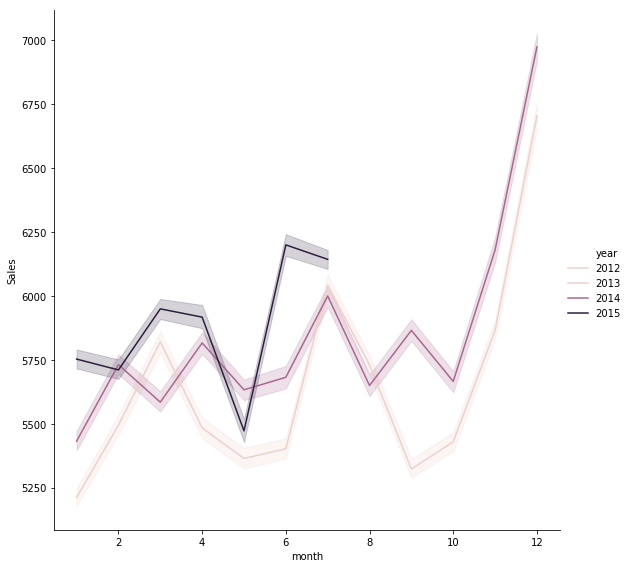

In [6]:
sns.relplot(x='month', y='Sales', hue='year', kind='line', data=df, height=8)
plt.show()

Based on our historical sales data we may wish to forecast future sales
so as to allocate our ressources optimally:

- How much floor space do we need?
- Should we increase storage capacity in certain areas?
- What are the factors that influence our sales and can we tweak those factors to influence our sales positively?

To answer some of these question we will survey and apply a number of basic
forecast models.
The intention here is not to develop a competitive model but rather to understand
some of the basic principles of forecasting that are part of cutting-edge models.

## Multiple linear regression model

Let us attempt to predict the **forecast variable** sales as a linear function
of **predictor variables** that we know ahead of time.
We could choose the number of customers on a given day but that is a time
series we also do not know in advance.

Hence, let us first attempt forecasting sales with something that we do
know ahead of time such as the day of the week.

Since there is no natural ordering
between weekdays (Is Sunday greater than Monday? Yes it is but not
in a way relevant to this forecasting exercise).
Hence we will translate each weekday to a separate boolean indicator variable
(this process is called one-hot encoding) such that our updated linear
model looks as follows:

$$ \textrm{sales}(t) = \beta_0 + \beta_1 \cdot \textrm{Monday}(t) + \cdots + \beta_7 \cdot \textrm{Sunday}(t) $$

Here $\textrm{Monday}(t)$ equals $1$ if $t$ corresponds to a Monday and $0$ otherwise - likewise
for the remaining weekdays.

We will use the open-source scikit-learn package to fit this linear model
against our historical data.
We will fit the parameters of the model on our observed sales data in the time period
January 1st, 2013 through December 31st, 2014.
We will then compare the predictions of our model for 2015 against our observations
of that year.

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
df = df.join(pd.get_dummies(df['Date'].dt.weekday_name))

In [9]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [10]:
X_train, y_train = df.loc[df['Date'] < '2015-01-01', weekdays], df.loc[df['Date'] < '2015-01-01', 'Sales']
X_test, y_test = df.loc[df['Date'] >= '2015-01-01', weekdays], df.loc[df['Date'] >= '2015-01-01', ['Date', 'Sales']]

In [11]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

/Users/gewa/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [12]:
y_test['sales_predicted'] = regressor.predict(X_test)

In [13]:
y_test = y_test.melt(id_vars=['Date'], value_vars=['Sales', 'sales_predicted'])

/Users/gewa/anaconda3/envs/kaggle/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


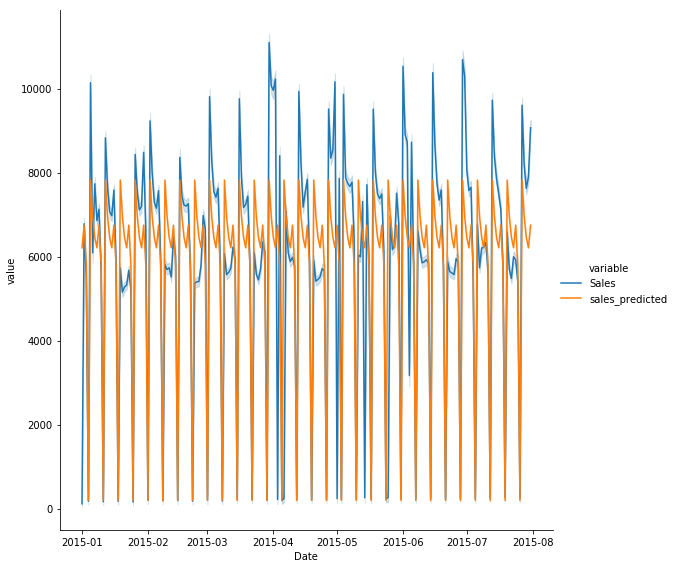

In [14]:
sns.relplot(x='Date', y='value', hue='variable', kind='line', data=y_test, height=8)
plt.show()

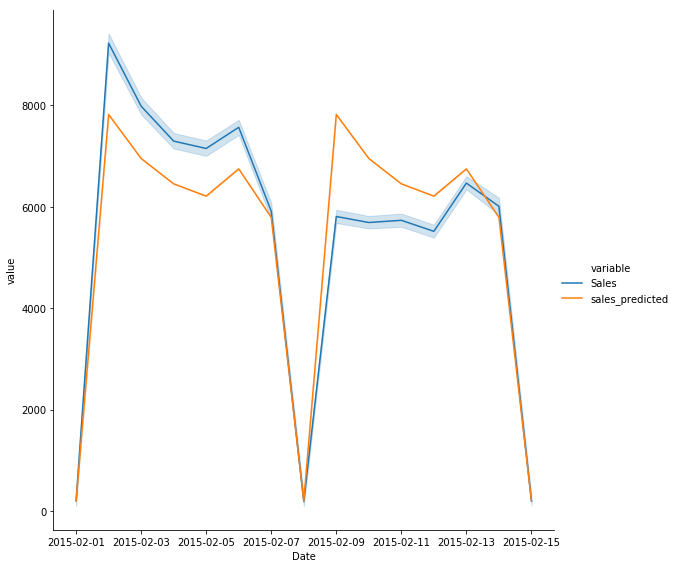

In [15]:
sns.relplot(
    x='Date',
    y='value',
    hue='variable',
    kind='line',
    data=y_test.loc[(y_test['Date'] >= '2015-02-01') & (y_test['Date'] <= '2015-02-15')],
    height=8
)
plt.show()

There is an apparent weekly pattern in our sales data:

Sundays and bank holidays retail stores are shut in Germany,
and there appear to be weekly sales peaks on Mondays and Fridays.

Our simplistic linear model based solely on weekdays forecasts
sales for Sundays really well and also captures supposed
peaks in sales on Mondays and Fridays pretty well.

Due to the nature of our model our sales forecast is also repetitive
across weeks.

## Exponential smoothing

In exponential smoothing we forecast sales in the future as a weighted average
of past sales:

$$ \textrm{sales}(t) = \alpha \cdot \textrm{sales}(t-1) + \alpha \cdot (1 - \alpha) \cdot \textrm{sales}(t-2) + \alpha \cdot (1 - \alpha)^2 \cdot \textrm{sales}(t-3) + \cdots $$

This particular model is called simple exponential smoothing or SES.

With $0 \leq \alpha \leq 1$ the weights of the observations decrease
exponentially as we go back in time.

Let us test this model using the open-source Python package `statsmodels`.

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

To simplify things we will attempt to predict mean sales
on a given day across all stores in our data set.

As we are not using independent predictor variables in this approach
we will not need to retrieve an X matrix of features here:

In [17]:
average_sales = df.groupby('Date')['Sales'].mean()

In [18]:
y_train = average_sales.loc[:'2015-01-01']

In [19]:
regressor = SimpleExpSmoothing(y_train.values)

In [20]:
regressor_fit = regressor.fit(smoothing_level=.9)

In [21]:
y_test = average_sales.loc['2015-01-01':].to_frame().reset_index()
y_test['sales_predicted'] = regressor_fit.predict(start=3, end=y_test.shape[0] + 2)

In [22]:
y_test = y_test.melt(id_vars=['Date'], value_vars=['Sales', 'sales_predicted'])

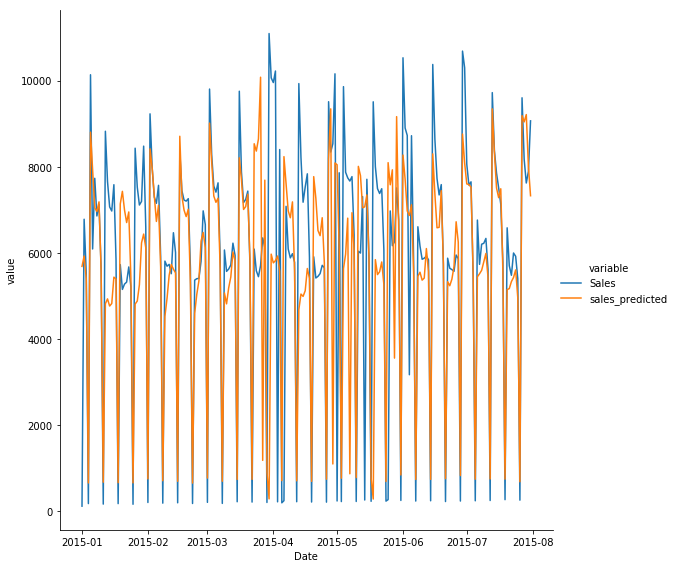

In [23]:
sns.relplot(x='Date', y='value', hue='variable', kind='line', data=y_test, height=8)
plt.show()

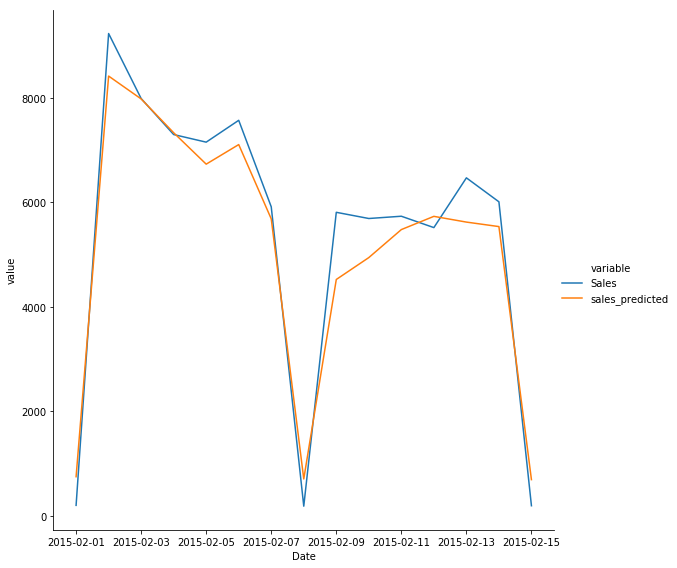

In [24]:
sns.relplot(
    x='Date',
    y='value',
    hue='variable',
    kind='line',
    data=y_test.loc[(y_test['Date'] >= '2015-02-01') & (y_test['Date'] <= '2015-02-15')],
    height=8
)
plt.show()

Visually some time windows of our forecast appear accurate
while in other parts of the time series our forecast is
substantially off.

## Autoregressive multiple regression

Since using past sales works somewhat well (at least to some extent)
for forecasting future sales, let us combine our two approaches so far:

Here we will forecast sales based on previous sales and further use
one-hot encoded weekdays as predictor variables.

Using today's sales numbers to predict tomorrow's does not help
us much if we intend to manage our ressources based on our forecasts.
To this end we will try and use last week's sales numbers to predict tomorrow's,
giving us enough to allocate our ressources as needed.

In [25]:
average_sales = average_sales.to_frame()

In [26]:
average_sales = average_sales.reset_index()

In [27]:
average_sales = average_sales.join(pd.get_dummies(average_sales['Date'].dt.weekday_name))

In [28]:
average_sales['sales_last_week'] = average_sales['Sales'].shift(-7)

In [29]:
average_sales = average_sales.dropna()

In [30]:
X_train, y_train = average_sales.loc[average_sales['Date'] < '2015-01-01', ['sales_last_week'] + weekdays], average_sales.loc[average_sales['Date'] < '2015-01-01', 'Sales']
X_test, y_test = average_sales.loc[average_sales['Date'] >= '2015-01-01', ['sales_last_week'] + weekdays], average_sales.loc[average_sales['Date'] >= '2015-01-01', ['Date', 'Sales']]

In [31]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [32]:
y_test['sales_predicted'] = regressor.predict(X_test)

In [33]:
y_test = y_test.melt(id_vars=['Date'], value_vars=['Sales', 'sales_predicted'])

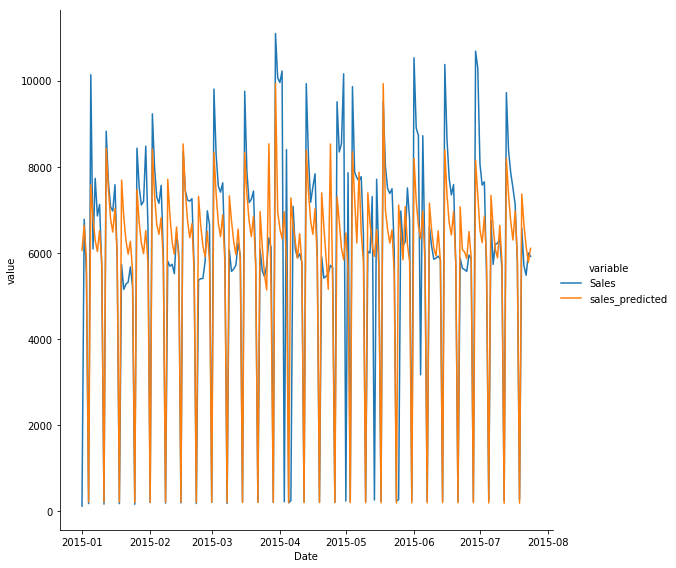

In [34]:
sns.relplot(x='Date', y='value', hue='variable', kind='line', data=y_test, height=8)
plt.show()

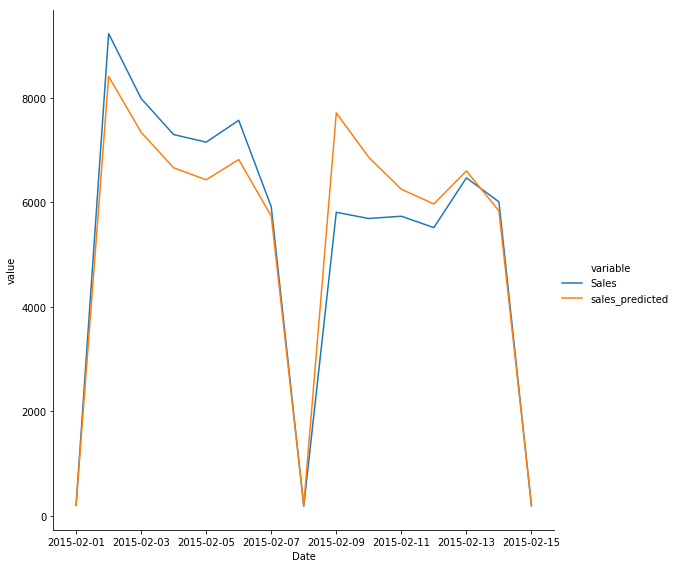

In [35]:
sns.relplot(
    x='Date',
    y='value',
    hue='variable',
    kind='line',
    data=y_test.loc[(y_test['Date'] >= '2015-02-01') & (y_test['Date'] <= '2015-02-15')],
    height=8
)
plt.show()

Judging by a visual comparison between actual and forecast sales,
our combined model does a superior job at predicting Sundays than
our exponential smoothing model.

This model furthe retains the weekly peaks observed on Mondays and Fridays
(something that got lost in the exponential smoothing model)
while also adjusting for weekly variances in overall sales levels -
the latter is an improvement over our first model which predicted identical
sales levels for all weeks.

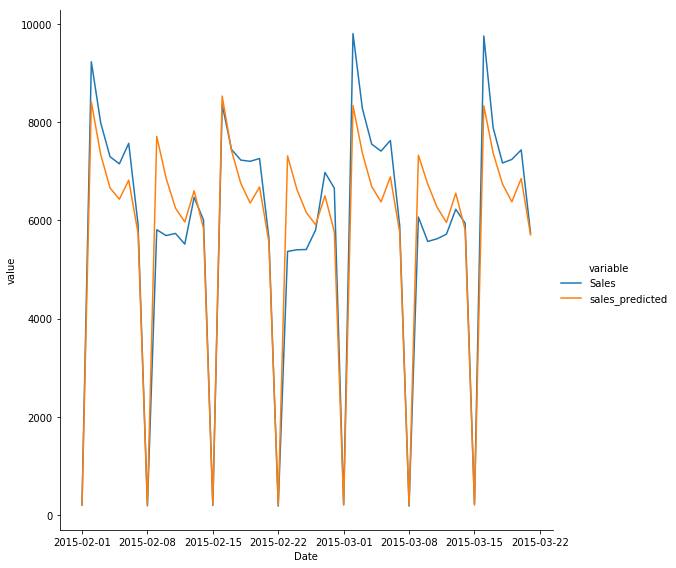

In [36]:
sns.relplot(
    x='Date',
    y='value',
    hue='variable',
    kind='line',
    data=y_test.loc[(y_test['Date'] >= '2015-02-01') & (y_test['Date'] <= '2015-03-21')],
    height=8
)
plt.show()

Extending our detailed plot in time we notice intriguing patterns
in our observed sales numbers where a Monday peak one week appears to
be followed by a Friday peak the week after.

Further, a week with overall greater sales volume appears to be followed
by one with overall lower sales and vice versa.

In a future blog article we will discuss analyzing these time series patterns
and using them to further improve the predictive power of our our forecast models.